<img src="https://directorsblog.nih.gov/wp-content/uploads/2020/03/COVID-19-Card-3.jpg" width="400">

# <center>Covid-19 Deaths Prediction</center>

### Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import calendar

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## knn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_val = []

## Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score

## Random Forest
from sklearn.ensemble import RandomForestRegressor

### Reading Dataset and EDA

COVID-19 - Predicitons
In this is study it will be presented an exploratory data analysis for covid in XXXX, with a prediction of deaths using Linear regression.

https://github.com/microsoft/Bing-COVID-19-Data/tree/master/data

Bing COVID-19 data includes confirmed, fatal, and recovered cases from all regions, updated daily in a .csv file. If there is an update or correction to already-published data, the data file will be updated accordingly. To ensure the stability of the data we share, it will be released with a 24-hour delay.

* ID - Unique identifier
* Updated  - Datetime in UTC
* Confirmed - Confirmed case count for the region
* ConfirmedChange - Change of confirmed case count from the previous day
* Deaths - Death case count for the region
* DeathsChange - Change of death count from the previous day
* Recovered - Recovered count for the region
* RecoveredChange - Change of recovered case counts from the previous day
* Latitude - Latitude of the centroid of the region
* Longitude - Longitude of the centroid of the region
* ISO2 - 2 letter country code identifier
* ISO3 - 3 letter country code identifier
* Country_Region - Country/region
* AdminRegion1 - Region within Country_region
* AdminRegion2 - Region within AdminRegion1

In [2]:
covid19_df = pd.read_csv('https://media.githubusercontent.com/media/microsoft/Bing-COVID-19-Data/master/data/Bing-COVID19-Data.csv')

In [3]:
# check the first 5 dataframe entries
covid19_df.tail()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude,ISO2,ISO3,Country_Region,AdminRegion1,AdminRegion2
1839178,131788785,04/28/2021,38235,44.0,1565.0,0.0,35517.0,423.0,-19.00046,29.87184,ZW,ZWE,Zimbabwe,NaN,NaN
1839179,131788786,04/29/2021,38257,22.0,1567.0,2.0,35594.0,77.0,-19.00046,29.87184,ZW,ZWE,Zimbabwe,NaN,NaN
1839180,131788787,04/30/2021,38260,3.0,1567.0,0.0,35594.0,0.0,-19.00046,29.87184,ZW,ZWE,Zimbabwe,NaN,NaN
1839181,131788788,05/01/2021,38281,21.0,1568.0,1.0,35620.0,26.0,-19.00046,29.87184,ZW,ZWE,Zimbabwe,NaN,NaN
1839182,131788789,05/02/2021,38281,0.0,1570.0,2.0,35634.0,14.0,-19.00046,29.87184,ZW,ZWE,Zimbabwe,NaN,NaN


In [4]:
# the data set consists of 1788487 rows and 15 columns
covid19_df.shape

(1839183, 15)

In [5]:
# Now we will filter our dataset to get only records from Ireland
country = 'Ireland'
covid19_df = covid19_df.loc[covid19_df['Country_Region'] == country]

In [6]:
covid19_df.head()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude,ISO2,ISO3,Country_Region,AdminRegion1,AdminRegion2
446476,7160970,02/29/2020,1,NaN,0.0,NaN,NaN,NaN,53.18499,-8.14689,IE,IRL,Ireland,NaN,NaN
446477,341035,03/01/2020,1,0.0,0.0,0.0,NaN,NaN,53.18499,-8.14689,IE,IRL,Ireland,NaN,NaN
446478,341036,03/02/2020,1,0.0,0.0,0.0,NaN,NaN,53.18499,-8.14689,IE,IRL,Ireland,NaN,NaN
446479,7160973,03/03/2020,2,1.0,0.0,0.0,NaN,NaN,53.18499,-8.14689,IE,IRL,Ireland,NaN,NaN
446480,7160976,03/04/2020,6,4.0,0.0,0.0,NaN,NaN,53.18499,-8.14689,IE,IRL,Ireland,NaN,NaN


In [7]:
covid19_df.shape

(425, 15)

In [8]:
# object -> categorical -> strings
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 446476 to 446900
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               425 non-null    int64  
 1   Updated          425 non-null    object 
 2   Confirmed        425 non-null    int64  
 3   ConfirmedChange  424 non-null    float64
 4   Deaths           425 non-null    float64
 5   DeathsChange     424 non-null    float64
 6   Recovered        412 non-null    float64
 7   RecoveredChange  408 non-null    float64
 8   Latitude         425 non-null    float64
 9   Longitude        425 non-null    float64
 10  ISO2             425 non-null    object 
 11  ISO3             425 non-null    object 
 12  Country_Region   425 non-null    object 
 13  AdminRegion1     0 non-null      object 
 14  AdminRegion2     0 non-null      object 
dtypes: float64(7), int64(2), object(6)
memory usage: 53.1+ KB


### Data Preparation

In [9]:
# Now we are going to clean the dataset, because for our prediction not all variables are important

# We informe the axis because we will remove all the lines of this column, 
# and also put we want to remove the lines from this column by inplace=true.

# We are droping the column 'ISO2' because it's irrelevant for our prediction
covid19_df.drop('ISO2', axis=1, inplace=True)

In [10]:
# We will check the variable 'ISO3' and check how many registers we have in there
covid19_df['ISO3'].value_counts()

IRL    425
Name: ISO3, dtype: int64

In [11]:
# The of information in 'ISO3' are IRE, and also we will drop this column because as 'ISO2' ISO3 is 
# not important for this prediction
covid19_df.drop('ISO3', axis=1, inplace=True)

In [12]:
# The next step is verify if the dataset has any missing value, as we can set some of our variables have missing value, 
# where it's represented by True or False
covid19_df.isna().any()

ID                 False
Updated            False
Confirmed          False
ConfirmedChange     True
Deaths             False
DeathsChange        True
Recovered           True
RecoveredChange     True
Latitude           False
Longitude          False
Country_Region     False
AdminRegion1        True
AdminRegion2        True
dtype: bool

In [13]:
# For those which have missing values, we will verify how many missing values for each variable
# For some variables there are too many values missing, like 'AdminRegion1'
# There is two approach we could handle this, we can remove or replace
covid19_df.isna().sum()

ID                   0
Updated              0
Confirmed            0
ConfirmedChange      1
Deaths               0
DeathsChange         1
Recovered           13
RecoveredChange     17
Latitude             0
Longitude            0
Country_Region       0
AdminRegion1       425
AdminRegion2       425
dtype: int64

In [14]:
# The procedure that we will address in this case is discarding lines that have few missing values
# where the number of missing values is low
# as we are dropping columns, we will put in this case axis=1
covid19_df.drop(columns=['AdminRegion1', 'AdminRegion2', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [15]:
covid19_df.isna().sum()

ID                  0
Updated             0
Confirmed           0
ConfirmedChange     1
Deaths              0
DeathsChange        1
Recovered          13
RecoveredChange    17
Country_Region      0
dtype: int64

In [16]:
# covid19_df['ConfirmedChange'].fillna(0, inplace=True)
#covid19_df['Deaths'].fillna(0, inplace=True)
#covid19_df['DeathsChange'].fillna(0, inplace=True)
#covid19_df['Recovered'].fillna(0, inplace=True)
#covid19_df['RecoveredChange'].fillna(0, inplace=True)

covid19_df.dropna(axis=0, subset=['ConfirmedChange', 'Deaths', 'DeathsChange', 'Recovered', 'RecoveredChange'], inplace=True)

In [17]:
# After doing all this procedures of dropping the lines with missing values, we will now check if there is still missing any value;
covid19_df.isna().sum()

ID                 0
Updated            0
Confirmed          0
ConfirmedChange    0
Deaths             0
DeathsChange       0
Recovered          0
RecoveredChange    0
Country_Region     0
dtype: int64

In [18]:
# We also need to check if there is any duplicated value, and also check what we should do if there is any.
covid19_df.duplicated().sum()

0

In [19]:
covid19_df.shape

(408, 9)

In [20]:
covid19_df.head()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Country_Region
446483,7160984,03/07/2020,19,1.0,0.0,0.0,0.0,0.0,Ireland
446484,7160987,03/08/2020,21,2.0,0.0,0.0,0.0,0.0,Ireland
446487,7160992,03/11/2020,43,9.0,1.0,1.0,0.0,0.0,Ireland
446488,7160993,03/12/2020,70,27.0,1.0,0.0,0.0,0.0,Ireland
446489,7160995,03/13/2020,90,20.0,1.0,0.0,0.0,0.0,Ireland


In [21]:
copy_safe = covid19_df.copy()
# covid19_df = copy_safe.copy();

In [22]:
# Converting the 'Updated' column to DateTime
covid19_df['Updated'] = pd.to_datetime(covid19_df['Updated'])
covid19_df.head()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Country_Region
446483,7160984,2020-03-07,19,1.0,0.0,0.0,0.0,0.0,Ireland
446484,7160987,2020-03-08,21,2.0,0.0,0.0,0.0,0.0,Ireland
446487,7160992,2020-03-11,43,9.0,1.0,1.0,0.0,0.0,Ireland
446488,7160993,2020-03-12,70,27.0,1.0,0.0,0.0,0.0,Ireland
446489,7160995,2020-03-13,90,20.0,1.0,0.0,0.0,0.0,Ireland


In [23]:
# Gathering datetime information by 'month', 'year', 'month/year'
covid19_df['Month'] = pd.DatetimeIndex(covid19_df['Updated']).month
covid19_df['Year'] = pd.DatetimeIndex(covid19_df['Updated']).year
covid19_df['Month_Year'] = covid19_df['Month'].apply(lambda x: calendar.month_abbr[x]) + '/' + covid19_df['Year'].map(str)
covid19_df.head()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Country_Region,Month,Year,Month_Year
446483,7160984,2020-03-07,19,1.0,0.0,0.0,0.0,0.0,Ireland,3,2020,Mar/2020
446484,7160987,2020-03-08,21,2.0,0.0,0.0,0.0,0.0,Ireland,3,2020,Mar/2020
446487,7160992,2020-03-11,43,9.0,1.0,1.0,0.0,0.0,Ireland,3,2020,Mar/2020
446488,7160993,2020-03-12,70,27.0,1.0,0.0,0.0,0.0,Ireland,3,2020,Mar/2020
446489,7160995,2020-03-13,90,20.0,1.0,0.0,0.0,0.0,Ireland,3,2020,Mar/2020


In [24]:
covid19_df.tail()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Country_Region,Month,Year,Month_Year
446896,131728742,2021-04-28,248326,469.0,4896.0,12.0,23364.0,0.0,Ireland,4,2021,Apr/2021
446897,131728744,2021-04-29,248870,544.0,4899.0,3.0,23364.0,0.0,Ireland,4,2021,Apr/2021
446898,131728745,2021-04-30,249437,567.0,4903.0,4.0,23364.0,0.0,Ireland,4,2021,Apr/2021
446899,131728748,2021-05-01,249838,401.0,4906.0,3.0,23364.0,0.0,Ireland,5,2021,May/2021
446900,131728749,2021-05-02,249838,0.0,4906.0,0.0,23364.0,0.0,Ireland,5,2021,May/2021


### Visualization

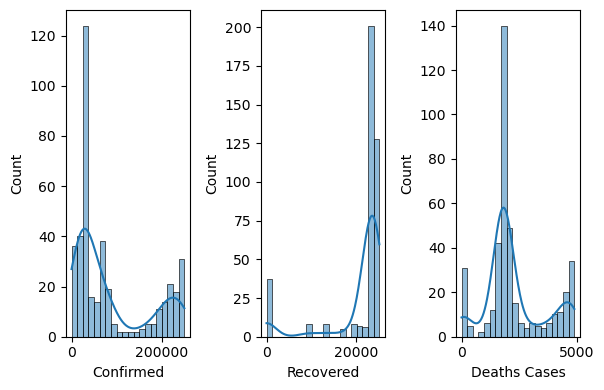

In [25]:
# We start with a simple Histogram to visualize the distribution of Confirmed Cases, Recovered Cases and Deaths
fig, ax = plt.subplots(1,3, dpi=100)

sns.histplot(covid19_df, x='Confirmed', bins=20, kde=True, ax=ax[0])
plt.xlabel('Confirmed Cases')

sns.histplot(covid19_df, x='Recovered', bins=20, kde=True, ax=ax[1])
plt.xlabel('Recovered')

sns.histplot(covid19_df, x='Deaths', bins=20, kde=True, ax=ax[2])
plt.xlabel('Deaths Cases')

plt.tight_layout();

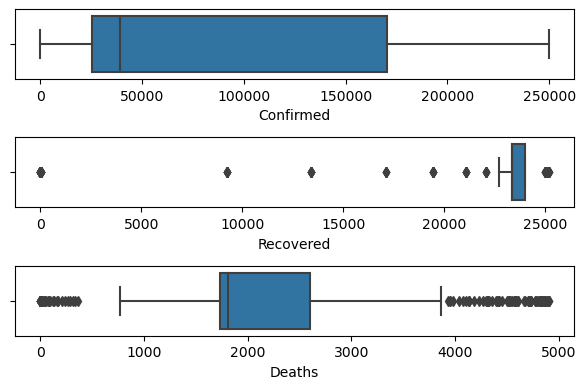

In [26]:
# Here we will plot box plots to identify outliers
fig, ax = plt.subplots(3,1, dpi=100)

sns.boxplot(x="Confirmed", data=covid19_df, ax=ax[0])
sns.boxplot(x="Recovered", data=covid19_df, ax=ax[1])
sns.boxplot(x="Deaths", data=covid19_df, ax=ax[2])

plt.tight_layout();

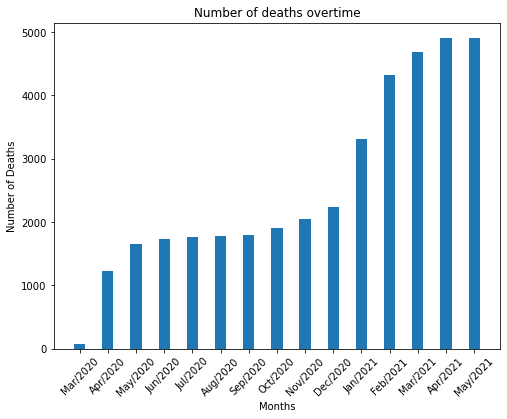

In [27]:
# Now we will visualize our dataset, in this case we will check the confirmed correlated with it's deaths. We want to check if
# there is anything in comum between them, we want to see if there any relationship.

plt.figure(figsize=(8, 6))
plt.bar(covid19_df['Month_Year'], covid19_df['Deaths'], width = 0.4) 
plt.xlabel("Months")
plt.ylabel("Number of Deaths")
plt.title("Number of deaths overtime")
plt.xticks(rotation=45)
plt.show()

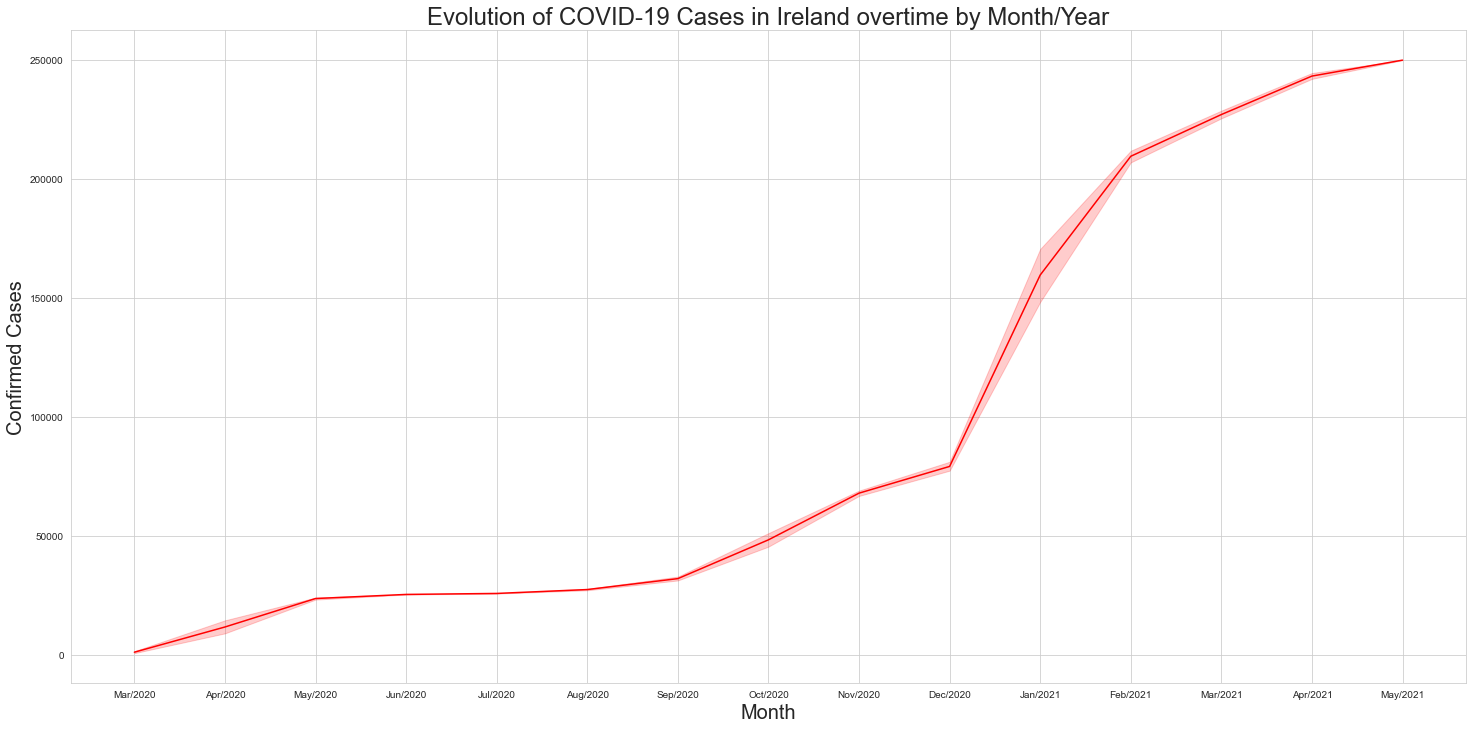

In [28]:
#Visualizing the data:
sns.set_style("whitegrid") 
sns.set_palette("Set1")
plt.figure(figsize=(25, 12))
sns.lineplot(data=covid19_df, x=covid19_df['Month_Year'], y=covid19_df['Confirmed'], color='red', sort=False, markers=True)
plt.title('Evolution of COVID-19 Cases in {} overtime by Month/Year'.format(country), fontsize= 24)
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Confirmed Cases', fontsize=20);

Text(0, 0.5, 'Total Number')

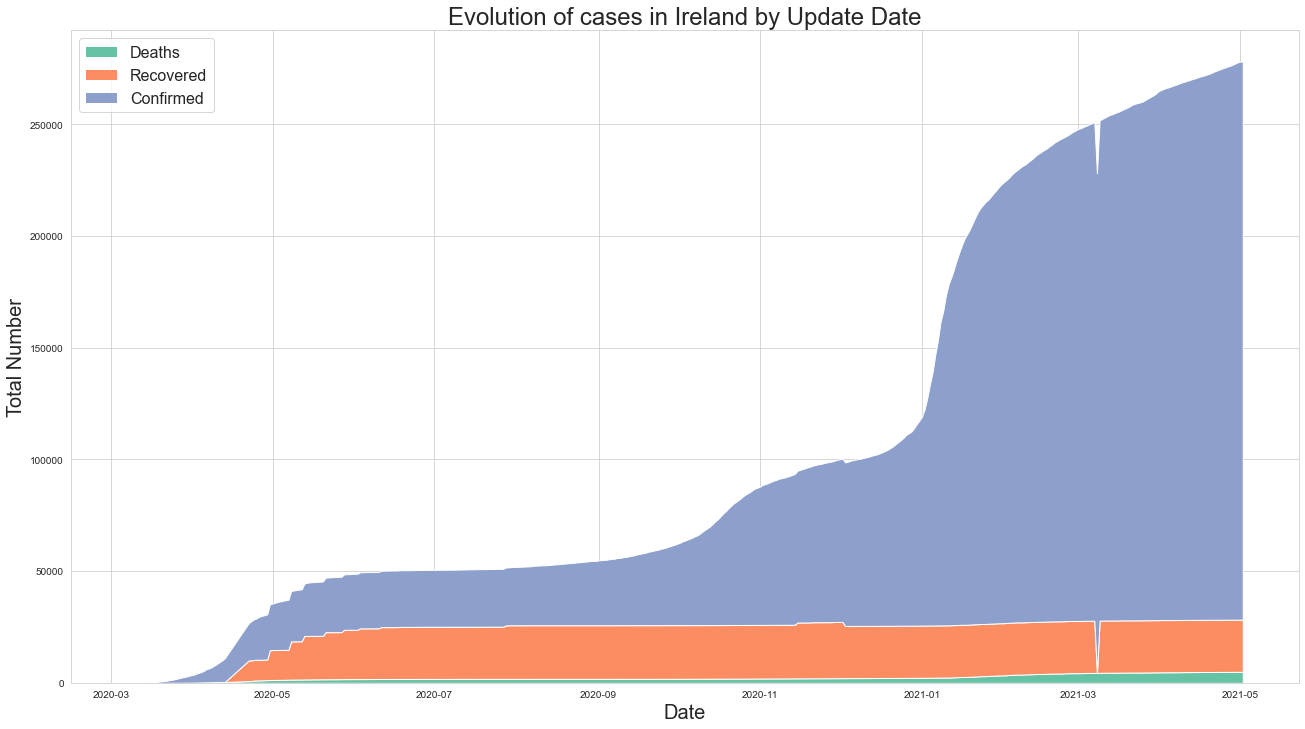

In [29]:
sns.set_palette("Set2")
sns.set_style("whitegrid") 

plt.figure(figsize=(22, 12))
plt.stackplot(covid19_df['Updated'], [covid19_df['Deaths'], covid19_df['Recovered'], covid19_df['Confirmed']],
              labels = ['Deaths', 'Recovered', 'Confirmed'])
plt.legend(loc = 'upper left', fontsize=16)
plt.title('Evolution of cases in {} by Update Date'.format(country), fontsize= 24)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Total Number', fontsize=20)

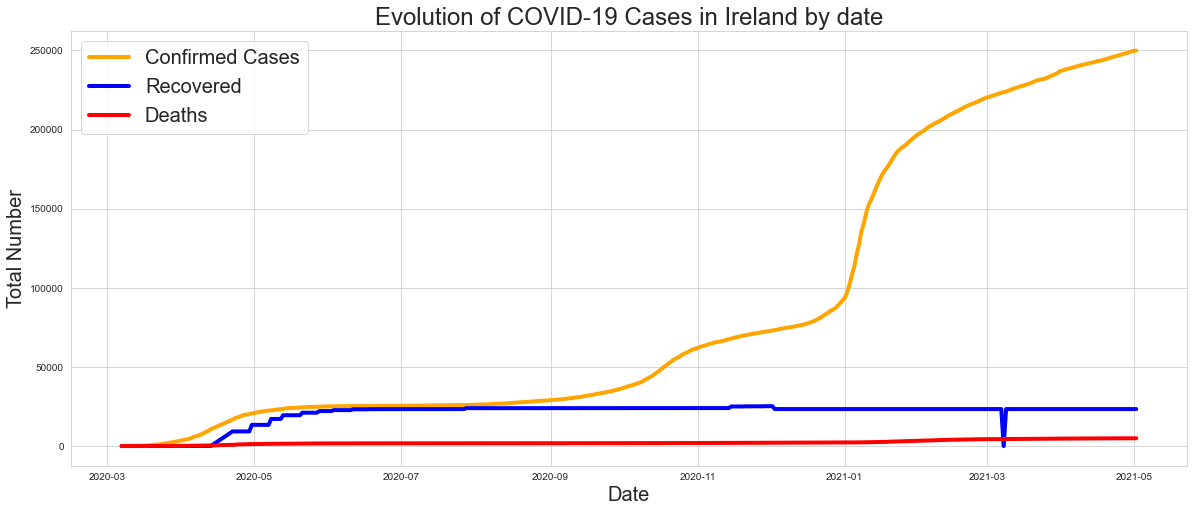

In [30]:
sns.set_style("whitegrid") 
plt.figure(figsize = (20,8))
plt. plot(covid19_df['Updated'], covid19_df['Confirmed'] , label = "Confirmed Cases", linewidth=4, color='orange')
plt. plot(covid19_df['Updated'], covid19_df['Recovered'] , label = "Recovered", linewidth=4, color='blue')
plt. plot(covid19_df['Updated'], covid19_df['Deaths'] , label = "Deaths", linewidth=4, color='red')
plt.title('Evolution of COVID-19 Cases in {} by date'.format(country), fontsize= 24)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Total Number', fontsize=20);
plt.legend(loc = 'upper left', fontsize=20);

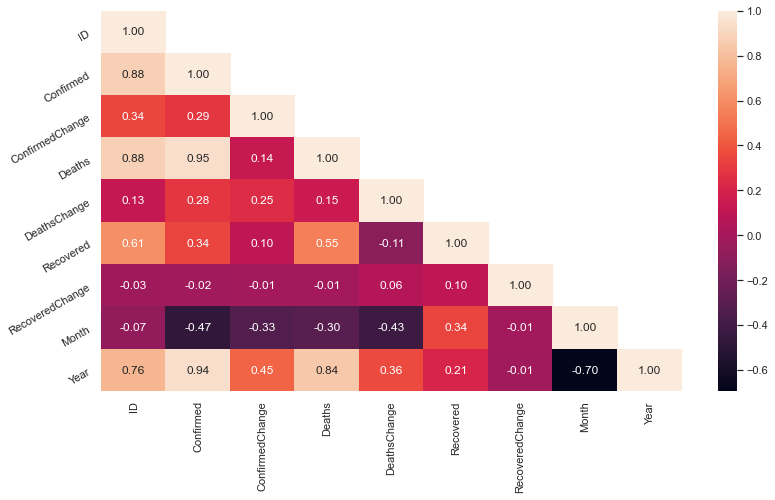

In [31]:
# Now let's look at the columns we have and show how they are correlated in each other,
# the more they are related the lighter the color will be, the less related it will be the darker

# We take all the correlation among the variables
corr = covid19_df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
heat_map = sns.heatmap(corr, mask=mask, annot=True, fmt='.2f')

rotx = heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90)
roty = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=30)

In [32]:
covid19_df.corr()

,ID,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Month,Year
ID,1.000000,0.879456,0.344991,0.880390,0.127260,0.605696,-0.029809,-0.074778,0.763862
Confirmed,0.879456,1.000000,0.286516,0.945532,0.284893,0.338166,-0.016259,-0.471218,0.944111
ConfirmedChange,0.344991,0.286516,1.000000,0.138405,0.245406,0.104032,-0.012160,-0.334903,0.449795
Deaths,0.880390,0.945532,0.138405,1.000000,0.149350,0.546955,-0.012960,-0.301557,0.842320
DeathsChange,0.127260,0.284893,0.245406,0.149350,1.000000,-0.111645,0.064192,-0.427153,0.363514
Recovered,0.605696,0.338166,0.104032,0.546955,-0.111645,1.000000,0.104943,0.337981,0.214475
RecoveredChange,-0.029809,-0.016259,-0.012160,-0.012960,0.064192,0.104943,1.000000,-0.010621,-0.013259
Month,-0.074778,-0.471218,-0.334903,-0.301557,-0.427153,0.337981,-0.010621,1.000000,-0.695378
Year,0.763862,0.944111,0.449795,0.842320,0.363514,0.214475,-0.013259,-0.695378,1.000000


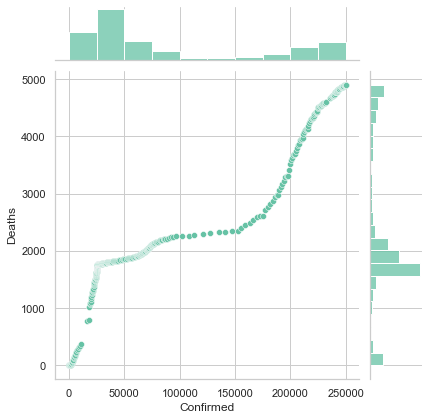

In [33]:
# As we saw in the heatmap above, the variables Confirmed Cases and Deaths showed a strong correlation. 
# We will check the correlation between Confirmed and Recovered Cases and Recovered Cases and Deaths as well.

sns.jointplot(x='Confirmed', y='Deaths',data=covid19_df, kind='scatter')

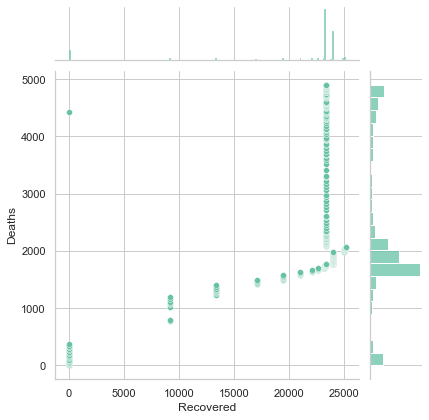

In [34]:
sns.jointplot(x='Recovered', y='Deaths', data=covid19_df, kind='scatter')

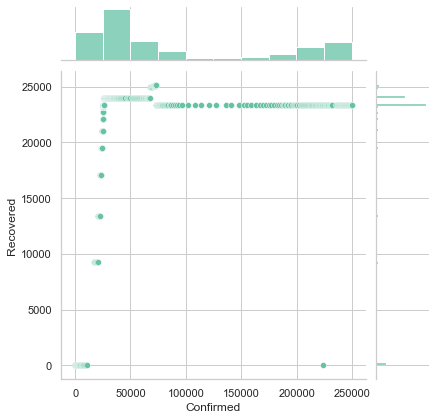

In [35]:
sns.jointplot(x='Confirmed', y='Recovered', data=covid19_df, kind='scatter')

In [36]:
# Number of death cases for 07th of March(07/03/2020) - the first day on the dataset 
print('First day in the dataset:', covid19_df['Updated'].iloc[0].strftime('%d/%m/%Y'))
print('Number of deaths: ', covid19_df['Deaths'].iloc[0])

First day in the dataset: 07/03/2020
Number of deaths:  0.0


In [37]:
# Number of death cases for the last day on the dataset
print('Last day in the dataset:', covid19_df['Updated'].iloc[-1].strftime('%d/%m/%Y'))
print('Number of deaths: ', covid19_df['Deaths'].iloc[-1])

Last day in the dataset: 02/05/2021
Number of deaths:  4906.0


The relationship between the Confirmed and Deaths by drawing the data points, and after that prepare the dependent and independent variables. Finally, dataset will be splitted.

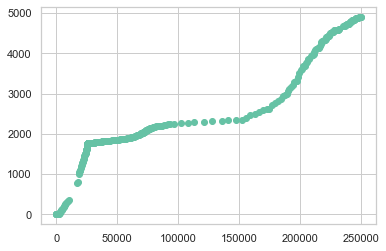

In [38]:
plt.scatter(covid19_df['Confirmed'], covid19_df['Deaths'])

### PCA - Feature importance

To determine which features are more important in the dataset, we will perform a PCA to identify them.

In [39]:
#First we will drop non-numerical features, irrelevant features and the target variable (Deaths).
#Then we will apply the PCA method

x = covid19_df.drop(covid19_df[['ID', 'Updated', 'Country_Region', 'Month_Year', 'Deaths']], axis=1)

pca = PCA(2)
projected = pca.fit_transform(x)

projected.shape

(408, 2)

In [40]:
# Creating a dataframe with the Principal Components and the target variable

covid_pca = pd.DataFrame(projected, columns =['C1', 'C2'])
covid_pca['Deaths'] = covid19_df['Deaths'].values
covid_pca.head()

,C1,C2,Deaths
0,-86540.874874,18303.540887,0.0
1,-86538.872183,18303.597285,0.0
2,-86516.856645,18304.222674,1.0
3,-86489.804507,18304.978507,1.0
4,-86469.837620,18305.560980,1.0


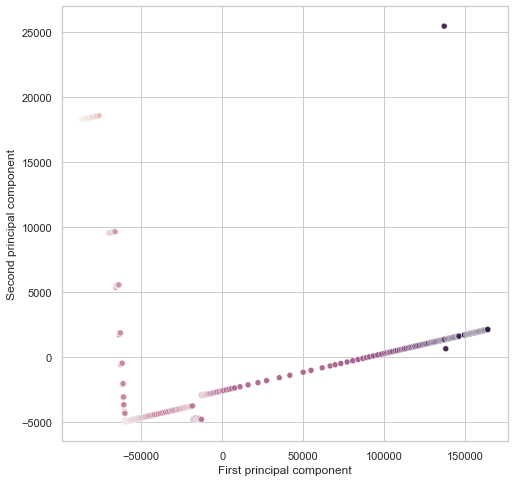

In [41]:
# Using a scatterplot to visualize the behaviour of the target in both components.

plt.figure(figsize=(8, 8))
c = sns.scatterplot(x='C1', y='C2', hue='Deaths', data=covid_pca)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
c.legend_.remove();

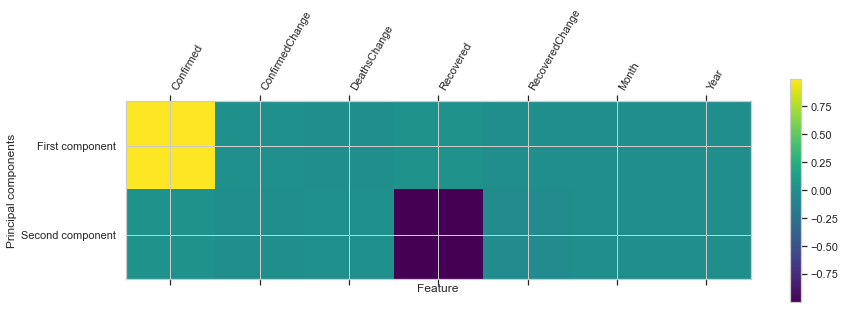

In [42]:
# Visualizing which features impact the most on the components

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1],["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(x.columns)),
x.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

The plot showed us that the two most important features are Confirmed and Recovered. This conclusion corresponds to what we observed on the heatmap, which showed us a strong correlation of the target variable wiht Confirmed Cases and a good correlation with Recovered Cases.

Due to those conclusions, we assigned 'Confirmed', 'Recovered' in y, so it's showing both of them. The variables were chosen because of the high level of correlation between them, as can be seen in the HeatMap and the PCA graph.

In [43]:
x = covid19_df[['Confirmed', 'Recovered']]
y = covid19_df['Deaths']
y = np.array(y).reshape(-1,1)

In [44]:
x.shape

(408, 2)

In [45]:
y.shape

(408, 1)

# Machine Learning

Once we split the data into x and y, now we can pass them into the train_test_split() function as a parameter along with test_size, and this function will return us four variables which are x_train, y_train, x_test, and y_test.

As many times as you run the above code, the code get a different result every time. This happens because the train_test_split() function picks up the random rows every time, and it’s good for our machine-learning model. If we don’t want the train_test_split() function to pick up the random rows, then you can do so by setting random_state = 10

The parameter test_size in the train_test_split() method defines the size of the testing data in a percentage. Let’s imagine we have 10000 rows, and if we define the size as test_size = 0.2, it means we want to keep 20% of the data of the datat for the testing, then in this, only 8000 rows will be used for training.

The next steps we are going to fit our variables x and y in each ML model to predict the output result.

### Linear Regression

Linear regression is a model that provide the linear relationship among variables, a dependent variable and independent vThe first model we applied was Linear Regression. Linear regression is a model that provide the linear relationship among variables, a dependent variable and an independent variable. This is quite a simple method, therefore we did not have any problem applying it.
After applying the model, we measured the accuracy for all test sizes and we did a Cross Validation of the model.
ariable. In this project as mentioned we will be using Confirmed and Recorved cases to predict the number of deaths.

In [46]:
# declaring arrays to store the results for each size(10%, 20% and 30%)
predictions_lin = []
linear_test_accurancy = []
linear_train_accuracy = []
linear_cross_validation = []

In [47]:
def calculateLinearRegression(size, _cv):
    # cv default value if None changed from 3-fold to 5-fold.
    
    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = size/100, random_state = 10)
    # fitting the x_train and y_train variables.
    linearRegressor = LinearRegression().fit(x_train, y_train)

    # predicting the output by passing the x_test variable.
    pred = linearRegressor.predict(x_test)
    predictions_lin.append(pred)
    
    test_accurancy = linearRegressor.score(x_test, y_test)*100
    linear_test_accurancy.append(test_accurancy)  
    
    train_accurancy = linearRegressor.score(x_train, y_train)*100
    linear_train_accuracy.append(train_accurancy)
    
    cross_validation = cross_val_score(linearRegressor, x_test, y_test, cv=_cv).mean()*100
    linear_cross_validation.append(cross_validation)

    # testing the accuracy of the model.
    print("Test size: {}%".format(size))
    print("Test set score: {:.2f}".format(test_accurancy))
    print("Training set score: {:.2f}".format(train_accurancy))
    
    # cross validation returns an array of scores of the estimator for each run of the cross validation.
    # if cv=5 the array will contains 5 scores.
    print("Cross Validation: {}\n".format(cross_validation))
    
    # Comparing predictions with linear regression and test data
    plt.figure(figsize=(14,6))
    plt.plot(pred, linestyle = 'dashed', linewidth = 3, label='Linear Regression Predictions {}%'.format(size))
    plt.plot(y_test, linewidth = 3, label = 'Test Data')
    plt.legend(loc = 'upper left', fontsize = 12);    

Linear Regression
Test size: 10%
Test set score: 90.53
Training set score: 95.53
Cross Validation: 90.72126803672501

Test size: 20%
Test set score: 92.39
Training set score: 95.69
Cross Validation: 92.17310912005505

Test size: 30%
Test set score: 94.27
Training set score: 95.55
Cross Validation: 93.42234130320328



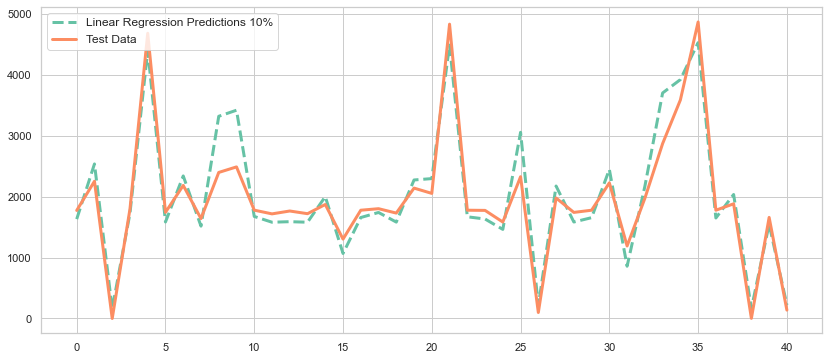

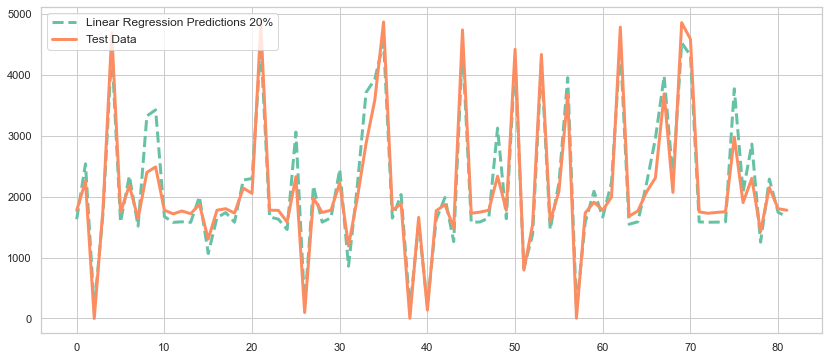

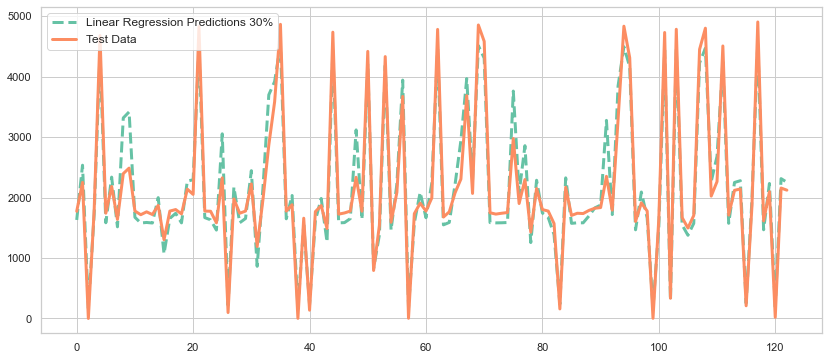

In [48]:
print("Linear Regression")
calculateLinearRegression(10, 3)
calculateLinearRegression(20, 3)
calculateLinearRegression(30, 3)

#### Conclusion
Based on that, it is possible to conclude that there is no over fitting or under fitting, because the test scores and training scores are quite similar and are really good. We also observed that the accuracy of the model is better for a 30% test size, based on the Cross Validation method.

### Ridge Regression

Ridge regression is a model based on linear regression, the difference is that Ridge is a more restrict model which reduce the overfitting chance. In this case as we saw in linear regression model, our data is not suffering from it, but we will try to see if there is any difference when applied this one to our model.

In [49]:
predictions_ridge = []
ridge_test_accurancy = []
ridge_train_accuracy = []
ridge_cross_validation = []

In [50]:
def calculateRidgeRegression(size, _cv):
    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = size/100, random_state = 10)
    # Train the Ridge() mode by calling a fit() method
    ridge = Ridge().fit(x_train, y_train)
    ridge10 = Ridge(alpha = 10).fit(x_train, y_train)
    ridge01 = Ridge(alpha=0.1).fit(x_train, y_train)
    
    pred = ridge.predict(x_test)
    predictions_ridge.append(pred);

    test_accurancy = ridge.score(x_test, y_test)*100
    ridge_test_accurancy.append(test_accurancy)
    
    train_accuracy = ridge.score(x_train, y_train)*100
    ridge_train_accuracy.append(train_accuracy)
    
    cross_validation = cross_val_score(ridge, x_test, y_test, cv=_cv).mean()*100
    ridge_cross_validation.append(cross_validation)
    
    print("Test size: {}%".format(size))
    print("Test set score: {:.2f}".format(test_accurancy))
    print("Training set score: {:.2f}".format(train_accuracy))
    print("Cross Validation: {}".format(cross_validation.mean()))
    
    print("Test (alpha=10) set score: {:.2f}".format(ridge10.score(x_test, y_test)*100))
    print("Training (alpha=10) set score: {:.2f}".format(ridge10.score(x_train, y_train)*100))
    print("Cross Validation (alpha=10): {}".format(cross_val_score(ridge10, x_test, y_test, cv=_cv).mean()*100))
    
    print("Test (alpha=0.1) set score: {:.2f}".format(ridge01.score(x_test, y_test)*100))
    print("Training (alpha=0.1) set score: {:.2f}".format(ridge01.score(x_train, y_train)*100))
    print("Cross Validation (alpha=0.1): {}\n".format(cross_val_score(ridge01, x_test, y_test, cv=_cv).mean()*100))
    
    # Comparing predictions with ridge regression and test data
    plt.figure(figsize=(14, 6))
    plt.plot(pred, linestyle = 'dashed', linewidth = 3, label='Ridge Regression Predictions {}%'.format(size))
    plt.plot(y_test, linewidth = 3, label = 'Test Data')
    plt.legend(loc = 'upper left', fontsize = 12)

Ridge Regression
Test size: 10%
Test set score: 90.53
Training set score: 95.53
Cross Validation: 90.72126803688275
Test (alpha=10) set score: 90.53
Training (alpha=10) set score: 95.53
Cross Validation (alpha=10): 90.72126803830223
Test (alpha=0.1) set score: 90.53
Training (alpha=0.1) set score: 95.53
Cross Validation (alpha=0.1): 90.72126803674078

Test size: 20%
Test set score: 92.39
Training set score: 95.69
Cross Validation: 92.17310912015031
Test (alpha=10) set score: 92.39
Training (alpha=10) set score: 95.69
Cross Validation (alpha=10): 92.17310912100774
Test (alpha=0.1) set score: 92.39
Training (alpha=0.1) set score: 95.69
Cross Validation (alpha=0.1): 92.17310912006455

Test size: 30%
Test set score: 94.27
Training set score: 95.55
Cross Validation: 93.42234130319004
Test (alpha=10) set score: 94.27
Training (alpha=10) set score: 95.55
Cross Validation (alpha=10): 93.4223413030707
Test (alpha=0.1) set score: 94.27
Training (alpha=0.1) set score: 95.55
Cross Validation (alph

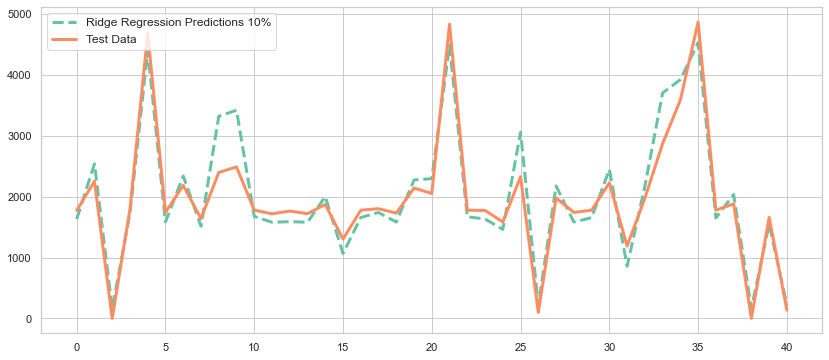

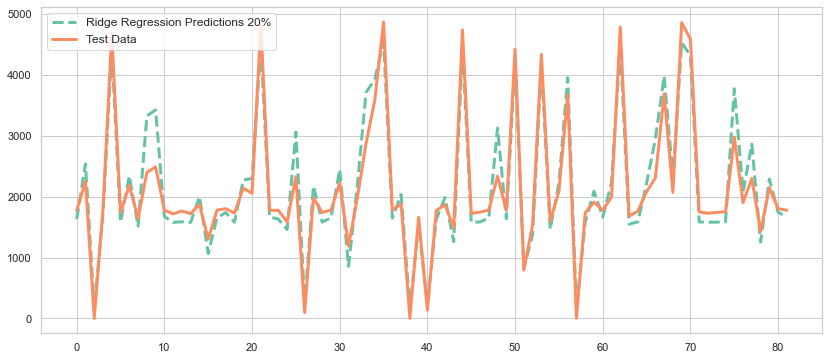

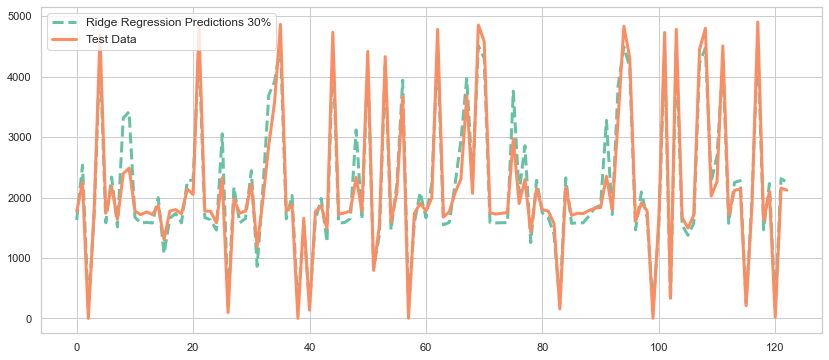

In [51]:
print("Ridge Regression")
calculateRidgeRegression(10, 3)
calculateRidgeRegression(20, 3)
calculateRidgeRegression(30, 3)

#### Conclusion

As mentioned before this model is a better when the dataset occurs to have overfitting, but we tried anyway to get our conclusion how it would impact in this dataset. We could see that we got no difference using Ridge, even when the alpha value applied, therefore, this would not be a good one model since we have our Linear Regression resulting a good performance.

### Polynomial Regression

Similar to Linear Regression, the Polynomial Regression analyse the relationship dependent variable and independent variable. The main difference is this kind of regression follows a non-linear model. As we saw in the jointplot, the distribution of number of deaths does not follow a linear model, that is why we decided to apply a polynomial model to compare the results with the linear model.

In [52]:
polynominal_prediction = []
polyregression_test_accurancy = []
polyregression_train_accurancy = []
polyregression_cross_validation = []

In [53]:
def calculatePolyminalRegression(size, _cv):
    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = size/100, random_state = 10)
    # for the degree we specify the dimension of our set;
    poly_features = PolynomialFeatures(degree = 1)
    
    x_train_poly = poly_features.fit_transform(x_train)
    x_test_poly = poly_features.transform(x_test)
    
    poly = LinearRegression()
    poly.fit(x_train_poly, y_train)
    
    pred = poly.predict(x_test_poly)
    polynominal_prediction.append(pred);
    
    test_accurancy = poly.score(x_train_poly, y_train)*100
    polyregression_test_accurancy.append(test_accurancy)
    
    train_accuracy = poly.score(x_train_poly, y_train)*100
    polyregression_train_accurancy.append(train_accuracy)
    
    cross_validation = cross_val_score(poly, x_test, y_test, cv=_cv).mean()*100
    polyregression_cross_validation.append(cross_validation)
    
    print("Test size: {}%".format(size))
    print("Test set score: {:.2f}".format(test_accurancy))
    print("Training set score: {:.2f}".format(train_accuracy))
    print("Cross Validation: {}\n".format(cross_validation))
    
    plt.figure(figsize=(14, 6))
    plt.plot(pred, linewidth=3, label='Polynomial Regression Predictions {}%'.format(size))
    plt.plot(y_test, linestyle = 'dashed', linewidth=3, label = 'Test Data')
    plt.legend(loc = 'upper left', fontsize=12);

Polyminal Regression
Test size: 10%
Test set score: 95.53
Training set score: 95.53
Cross Validation: 90.72126803672501

Test size: 20%
Test set score: 95.69
Training set score: 95.69
Cross Validation: 92.17310912005505

Test size: 30%
Test set score: 95.55
Training set score: 95.55
Cross Validation: 93.42234130320328



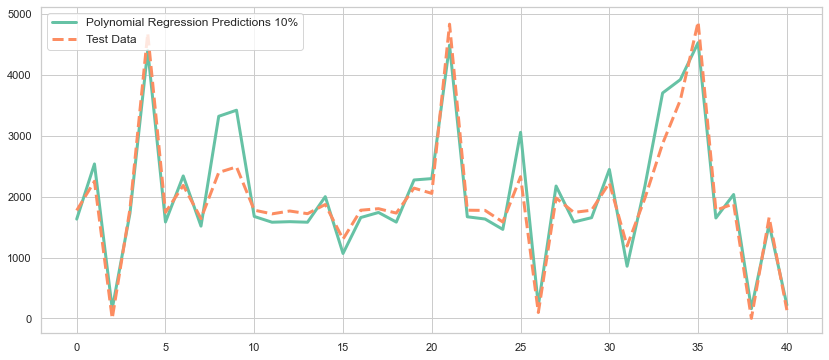

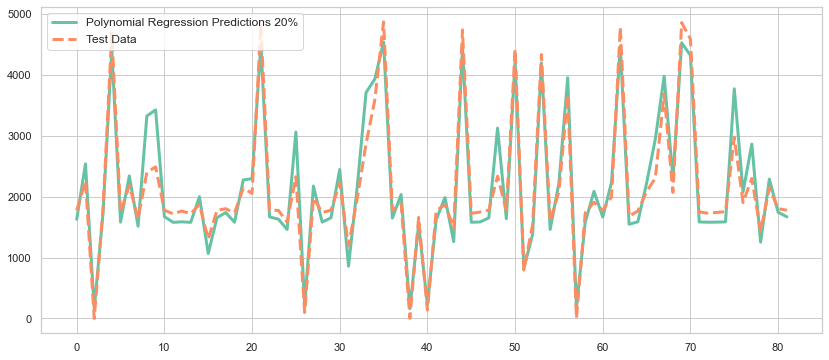

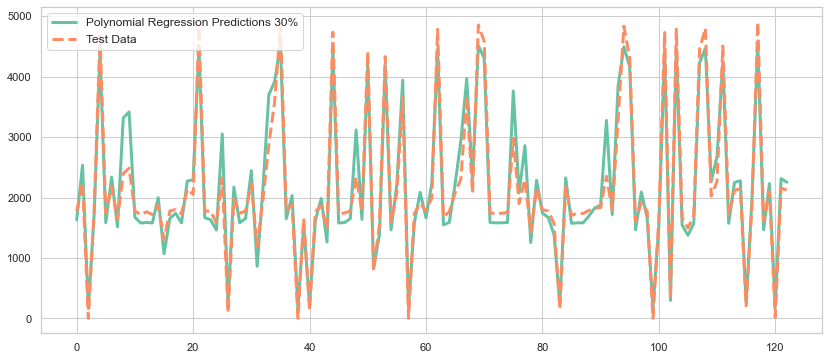

In [54]:
print("Polyminal Regression")
calculatePolyminalRegression(10, 3)
calculatePolyminalRegression(20, 3)
calculatePolyminalRegression(30, 3)

#### Conclusion

Applying the Polynomial transformation improved the accuracy of the test set compared to the Linear Regression method. However, the Cross Validation score did not show any changes, which means that the Linear method works fine with our dataset. 

### k Nearest Neighbors

We are going to fit our variables x and y in KNN (K Neighbors Regressor) machine learning model to predict the output result, but before we will check the best number of neighbors that fits better our model.

In [55]:
def calculateBestNumberNeighbors(size, neighbors):
    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = size/100, random_state = 10)
    # number of neighbors, here we defined 5
    num_neighbors = np.arange(1, neighbors)           
    train_accuracy = np.zeros(len(num_neighbors))
    test_accuracy = np.zeros(len(num_neighbors))

    # for loop that checks the model for neighbor values 1 up to 5
    for i, j in enumerate(num_neighbors):
        # instance an new object of KNeighborsRegressor, k means the number of each interation of the looping
        knn = KNeighborsRegressor(n_neighbors = j)   
        # fitting the model
        knn.fit(x_train, y_train)           
        # calculate the accuracy on the training set, then insert the value inside the train_accurancy array
        train_accuracy[i] = knn.score(x_train, y_train)*100  
        # same for test
        test_accuracy[i] = knn.score(x_test, y_test)*100
        
    # visualizing the previous process to analyse the best n_neighbors
    plt.figure(figsize=(8, 4))
    plt.plot(num_neighbors, test_accuracy, label='Test Accuracy'.format(size), color='r')
    plt.plot(num_neighbors, train_accuracy, label='Train accuracy', color='b')

    plt.legend(loc = 'upper right', fontsize=12);
    plt.xlabel('Number of neighbors', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.title('k Nearest Neighbors accuracy number of neighbors={} test size={}%'.format(neighbors, size), fontsize=15)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

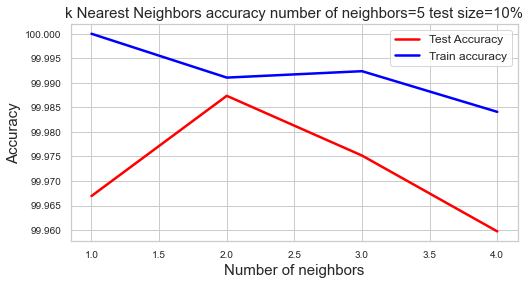

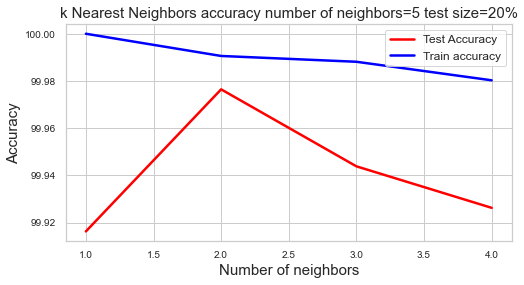

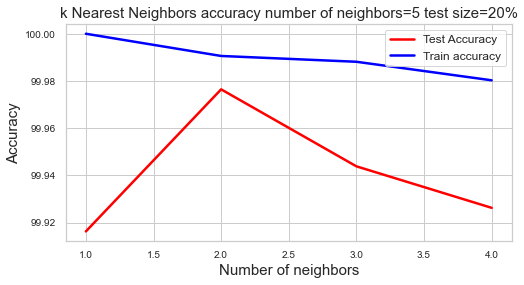

In [56]:
calculateBestNumberNeighbors(10, 5)
calculateBestNumberNeighbors(20, 5)
calculateBestNumberNeighbors(20, 5)

As the number of neighbors increase, the KNN accuracy drops. This happens because a higher value of neighbors reduces the edginess by taking more data into account, then it reduces complexity and flexibility of the model. In this case we can see from the graph when number neighbors equals to 2, the test and train performances are the best.

In [57]:
predictions_knn = []
knn_test_accurancy = []
knn_train_accuracy = []
knn_cross_validation = []

In [58]:
def calculateKNN(size, neighbors, _cv):
    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = size/100, random_state = 10)

    knn = KNeighborsRegressor(n_neighbors = neighbors)
    knn.fit(x_train, y_train)    
    
    pred = knn.predict(x_test)
    predictions_knn.append(pred)

    test_accurancy = knn.score(x_test, y_test)*100
    knn_test_accurancy.append(test_accurancy)
    
    train_accuracy = knn.score(x_train, y_train)*100
    knn_train_accuracy.append(train_accuracy)
    
    cross_validation = cross_val_score(knn, x_test, y_test, cv=_cv).mean()*100
    knn_cross_validation.append(cross_validation)

    # testing the accuracy of the model.
    print("Test size: {}%".format(size))
    print("Test set score: {:.2f}".format(test_accurancy))
    print("Training set score: {:.2f}".format(train_accuracy))
    print("Cross Validation: {}\n".format(cross_validation))
    
    plt.figure(figsize=(14, 6))
    plt.plot(pred, linestyle = 'dashed', linewidth=3, label='Predictions with kNN {}% neighbors={}'.format(size, neighbors))
    plt.plot(y_test, linestyle = 'dashed', linewidth=3, label = 'Test Data')
    plt.legend(loc = 'upper left', fontsize=12);

k Nearest Neighbors
Test size: 10%
Test set score: 99.99
Training set score: 99.99
Cross Validation: 99.17991931306453

Test size: 20%
Test set score: 99.98
Training set score: 99.99
Cross Validation: 99.07233554379864

Test size: 30%
Test set score: 99.98
Training set score: 99.99
Cross Validation: 99.60979801924246



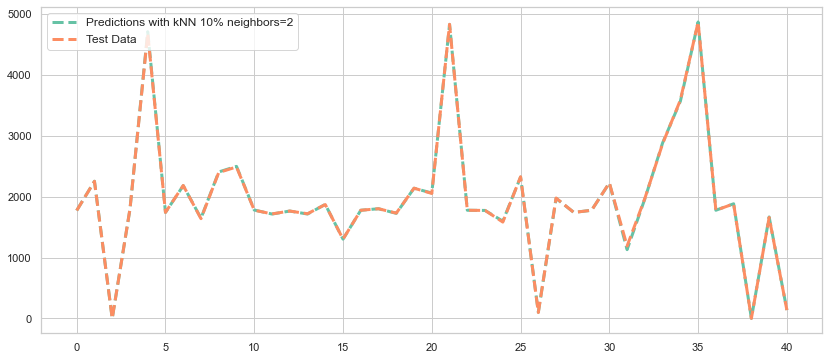

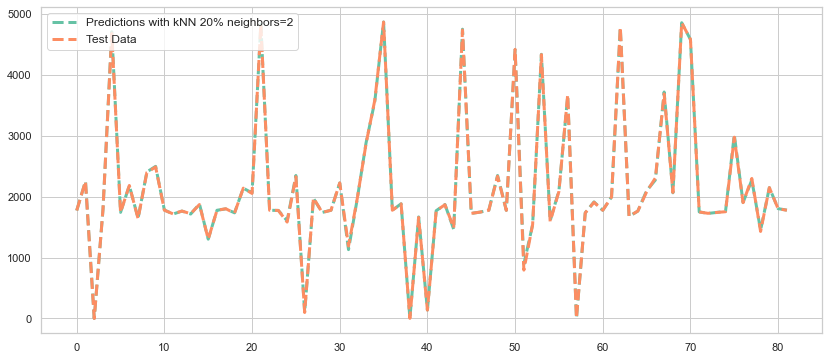

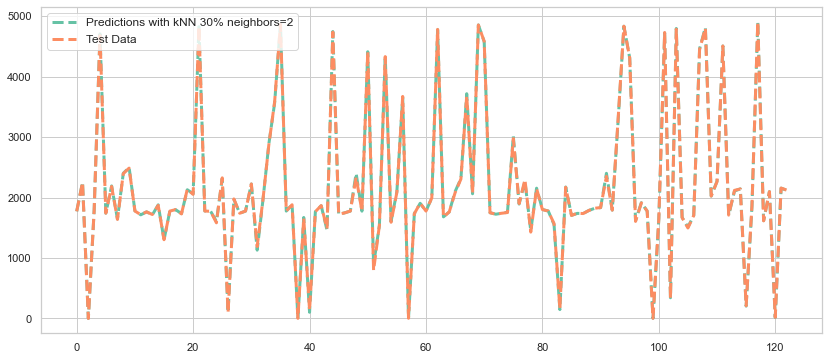

In [59]:
print('k Nearest Neighbors')
num_neighbors = 2
calculateKNN(10, num_neighbors, 3)
calculateKNN(20, num_neighbors, 3)
calculateKNN(30, num_neighbors, 3)

#### Conclusion

For this model we can conclude that the accuracy can be affected by the number of neighbors. It is possible to observe that the model got the best score so far, getting really close of 100%. There is no over fitting or under fitting, because the test scores and training scores are quite similar and are really good.

### Decision Tree Regressor

In this step we will fit our dataset in a decision tree. Decision trees can be divided into regression or classification. In this case we will be dividing our dataset in regression tree, the regression tree are used when the result variable are numeric or continuous.

For this model our criterion is different from the ones we use for classification trees, such as entropy, a measure of impurity. In this case we used regression tree, so we need a different impurity measure that fits this model. As we are dealing with continuous variables, we defined MSE (Mean Squared Error) of the nodes in the tree as the impurity measure.

In [60]:
decisiontree_prediction = []
decisiontree_test_accurancy = []
decisiontree_train_accurancy = []
decisiontree_cross_validation = []

In [61]:
def calculateDecisionTree(size, depth, cv_):
    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = size/100, random_state = 10)
    
    # initializing the tree with the criterion described above 
    # fitting = decision_tree.fit(x_train, y_train)
    decision_tree = DecisionTreeRegressor(criterion = 'mse', max_depth = depth).fit(x_train, y_train)

    # predicting a new result based on the tree
    pred = decision_tree.predict(x_test)
    decisiontree_prediction.append(pred)
    
    test_accurancy = decision_tree.score(x_test, y_test)*100
    decisiontree_test_accurancy.append(test_accurancy)
    
    train_accuracy = decision_tree.score(x_train, y_train)*100
    decisiontree_train_accurancy.append(train_accuracy)
    
    cross_validation = cross_val_score(decision_tree, x_test, y_test, cv=3).mean()*100
    decisiontree_cross_validation.append(cross_validation)
    
    print("Test size: {}%".format(size))
    print("Test set score: {:.2f}".format(test_accurancy))
    print("Training set score: {:.2f}".format(train_accuracy))
    print("Cross Validation:{}\n".format(cross_validation))
    
    plt.figure(figsize=(14, 6))
    plt.plot(pred, linestyle = 'dashed', linewidth=3, label='Predictions with Decision Tree Regressor {}%  depth={}'.format(size, depth))
    plt.plot(y_test, linestyle = 'dashed', linewidth=3, label = 'Test Data')
    plt.legend(loc = 'upper left', fontsize=12)
    
    fig = plt.figure(figsize=(25, 20))
    out = tree.plot_tree(decision_tree, feature_names=x.columns, filled=True)
    for o in out:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1.5);

Decision Tree Regressor
Test size: 10%
Test set score: 96.92
Training set score: 98.24
Cross Validation:95.1743409985177

Test size: 20%
Test set score: 96.98
Training set score: 98.31
Cross Validation:96.696130118325

Test size: 30%
Test set score: 98.06
Training set score: 98.20
Cross Validation:97.53639852770539



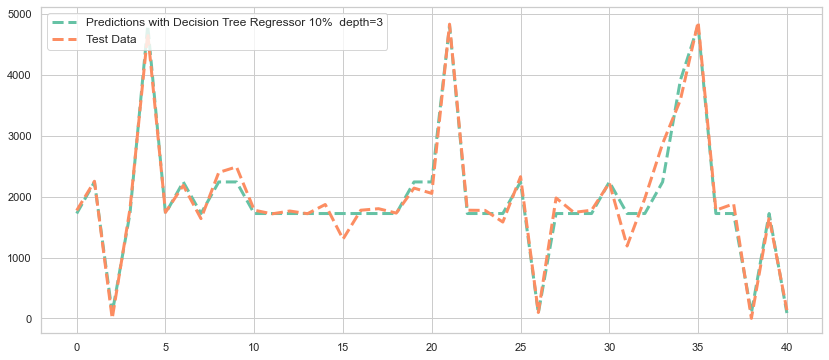

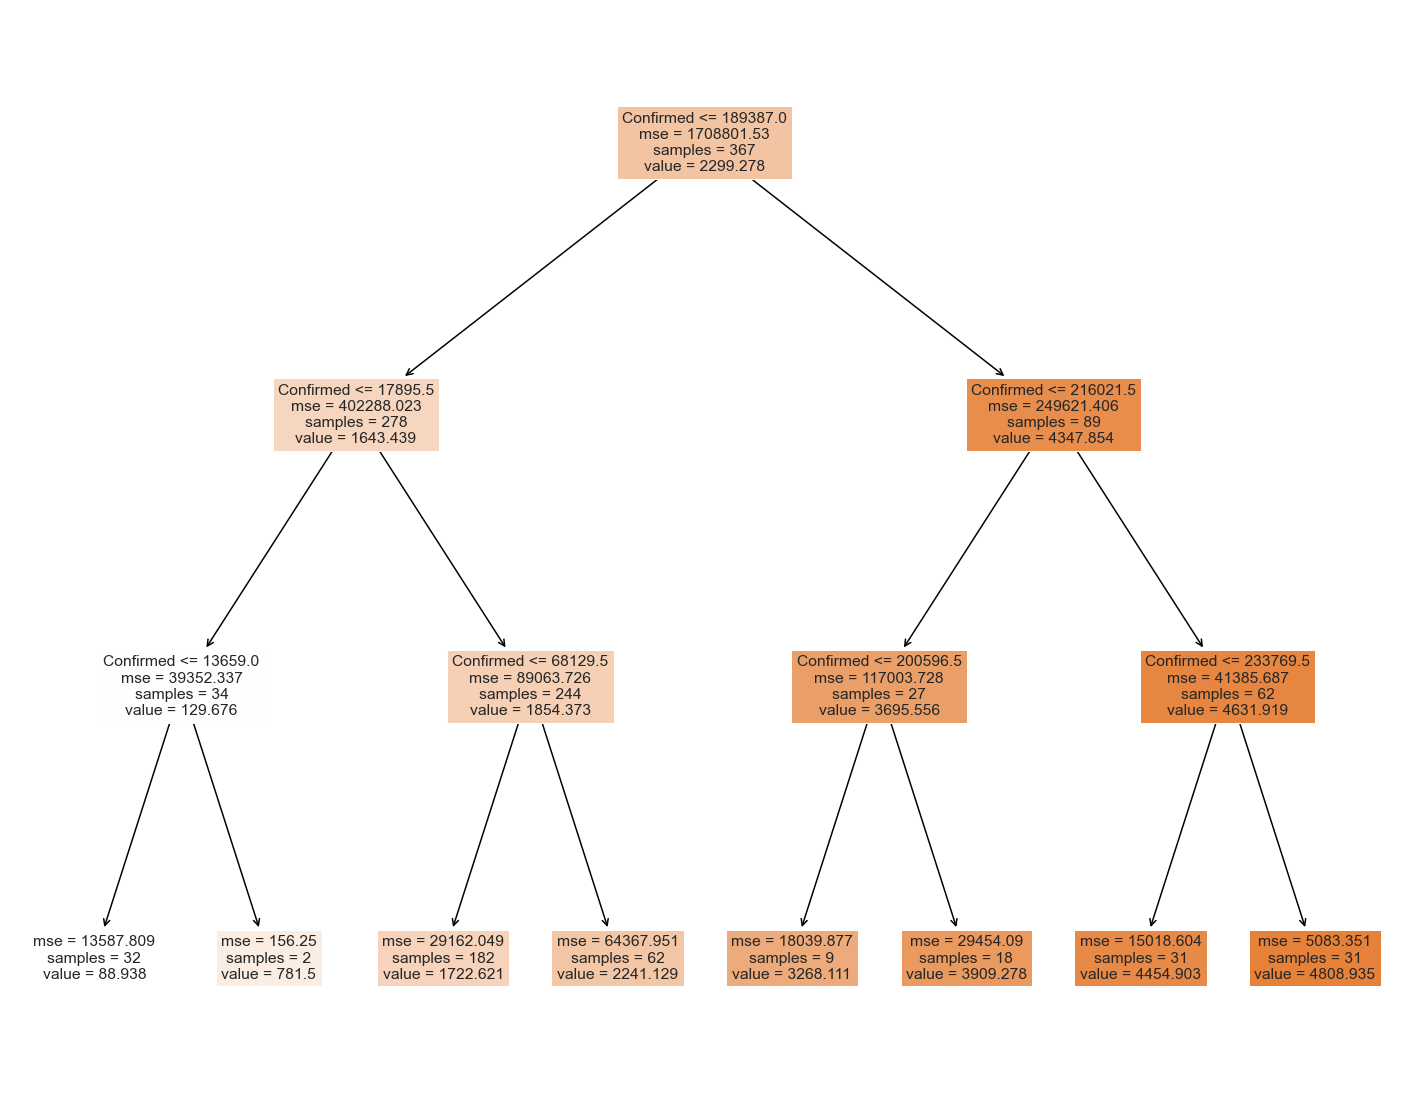

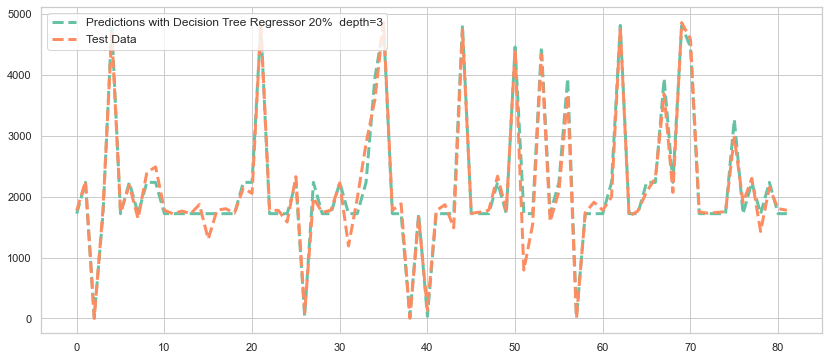

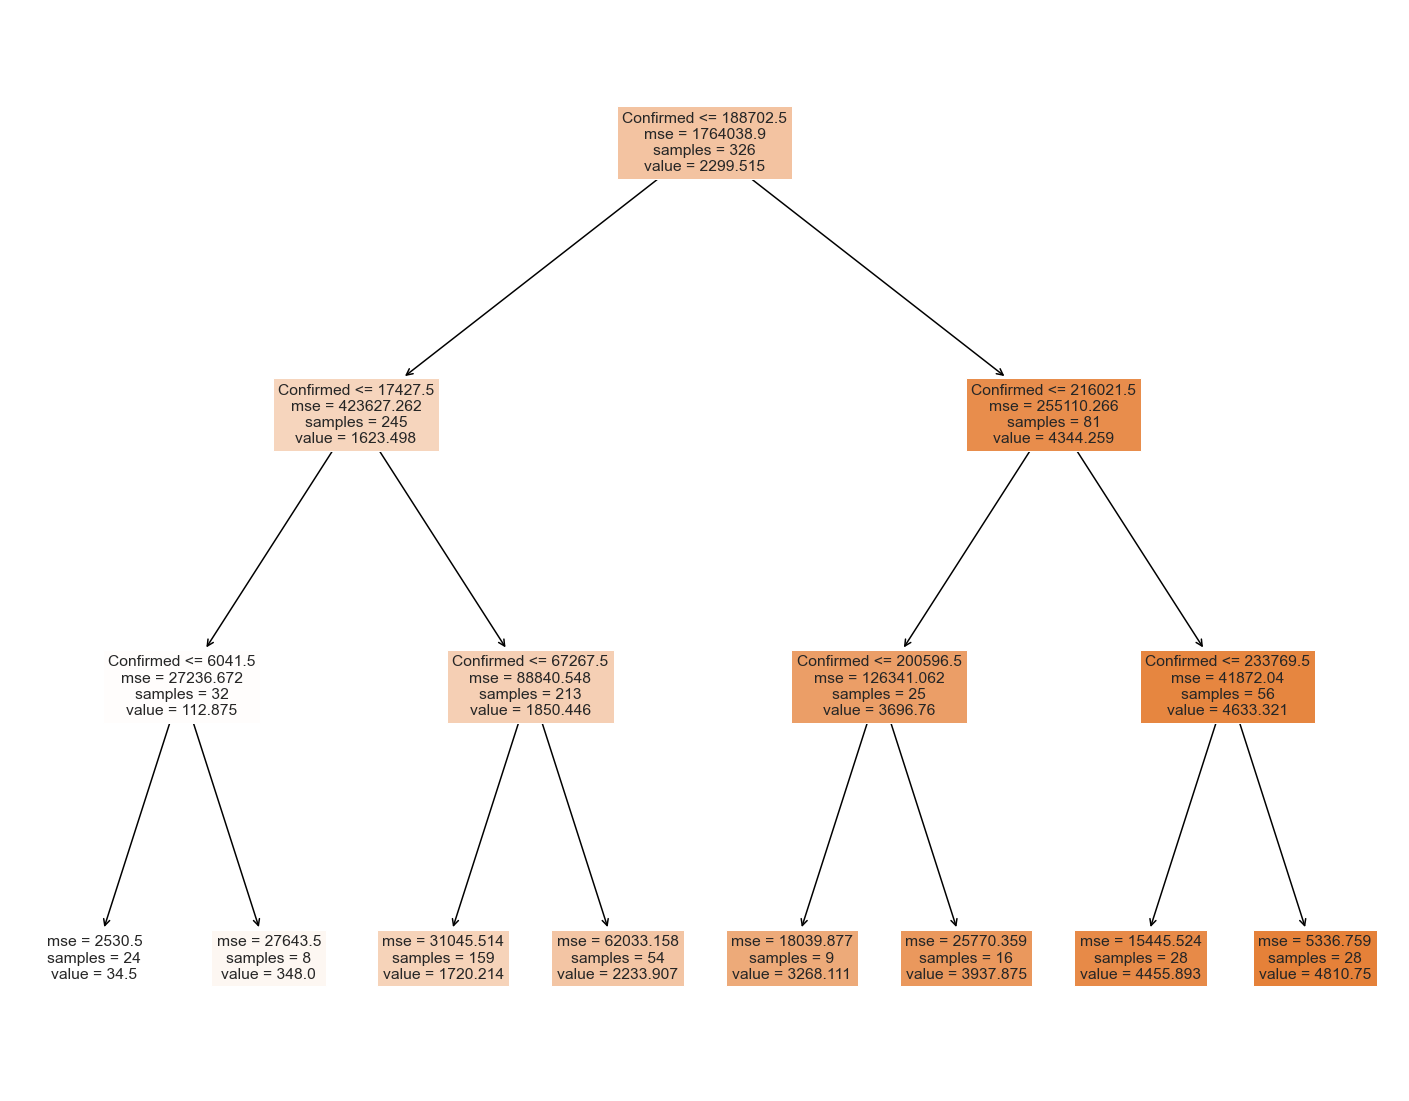

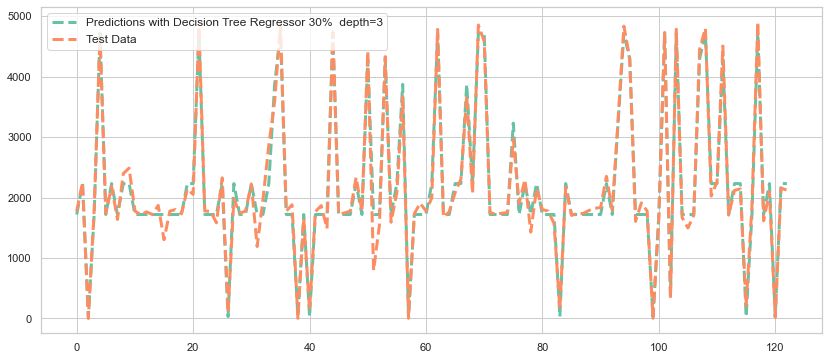

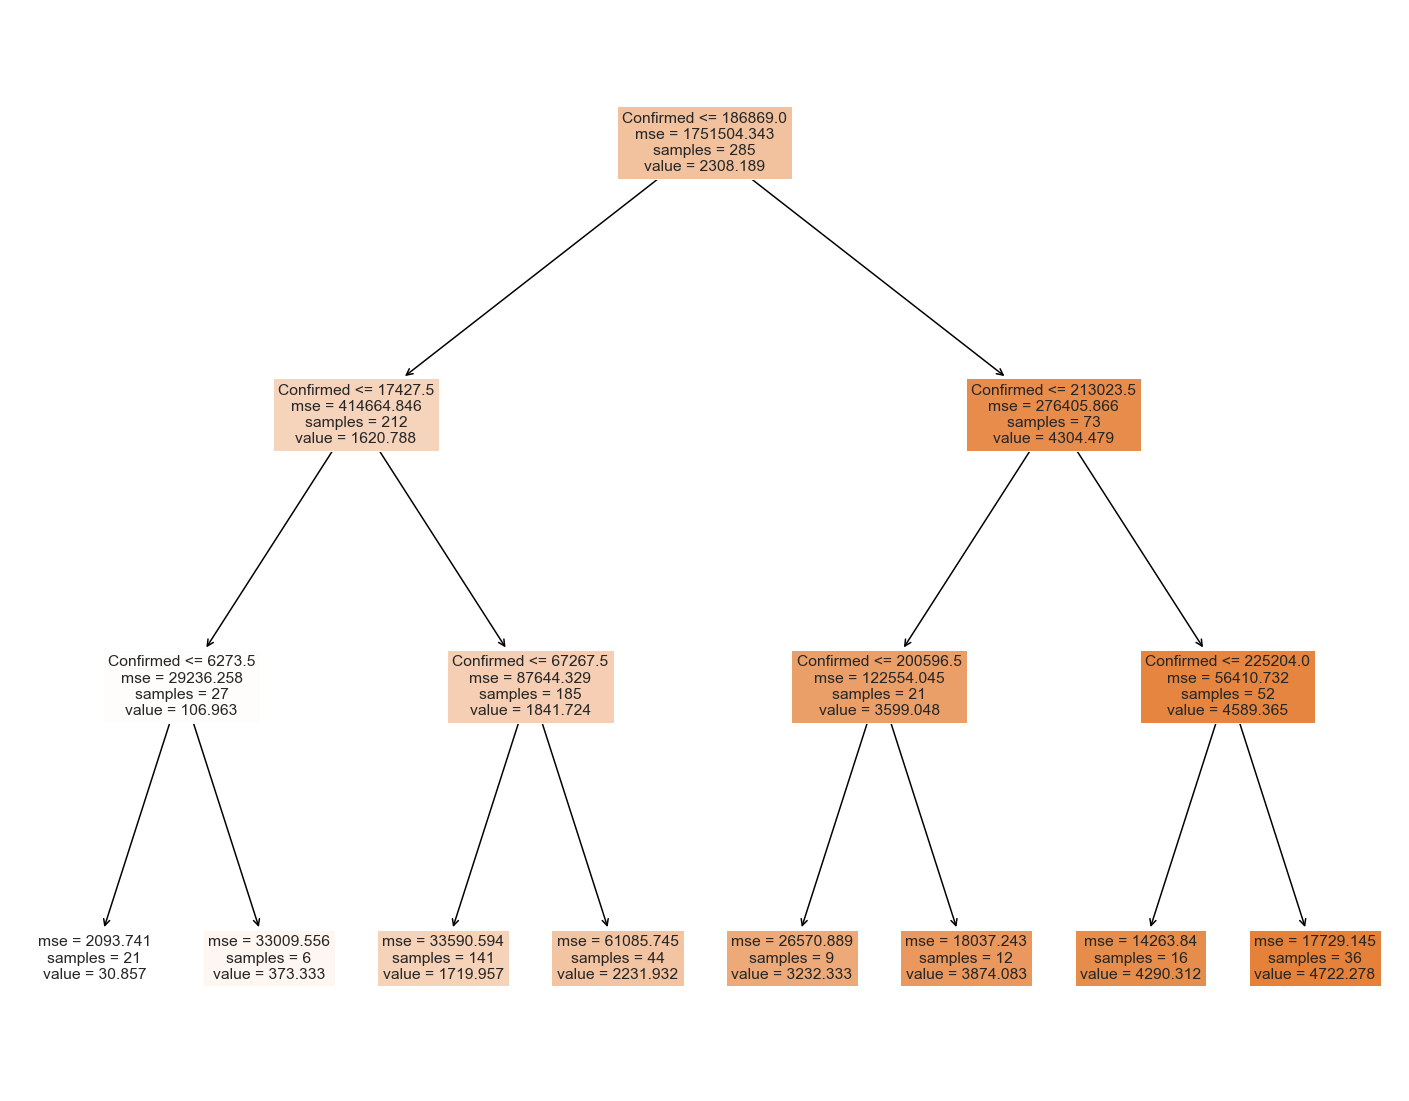

In [62]:
print('Decision Tree Regressor')
decision_tree_depth = 3

calculateDecisionTree(10, decision_tree_depth, 3)
calculateDecisionTree(20, decision_tree_depth, 3)
calculateDecisionTree(30, decision_tree_depth, 3)

#### Conclusion

We tested different depths for the tree and as we increase them, the accuracy improves. We decide to keep the depth equals to 3. The best performance was the 30% test size. There is no over fitting or under fitting, because the test scores and training scores are quite similar and are really good.

### Random Forests

Following the same logic of Decision Trees, we decided to apply Random Forest Regressor to our dataset to compare the accuracy between it and Decision Tree. We stated that the depth of the forest is 4 and the number of trees is 3.

In [63]:
predictions_randomforest = []
randomforest_test_accurancy = []
randomforest_train_accuracy = []
randomforest_cross_validation = []

In [64]:
def calculateRandomForest(size, cv_, depth, number_trees):
    x_train, x_test, y_train, y_test =  train_test_split(x, np.ravel(y), test_size = size/100, random_state = 10)
    
    ## randomforest = RandomForestRegressor(criterion = 'mse', n_estimators = number_trees, max_depth= depth, random_state=0) 
    ## randomforest = RandomForestRegressor(criterion="entropy", random_state=0) ##criterion="entropy",
    randomforest = RandomForestRegressor(criterion = 'mse', n_estimators = number_trees,
                                         max_depth= depth, random_state=0).fit(x_train, y_train)
    
    pred = randomforest.predict(x_test)
    predictions_randomforest.append(pred)

    test_accurancy = randomforest.score(x_test, y_test)*100
    randomforest_test_accurancy.append(test_accurancy)
    
    train_accuracy = randomforest.score(x_train, y_train)*100
    randomforest_train_accuracy.append(train_accuracy)
    
    cross_validation = cross_val_score(randomforest, x_test, y_test, cv=3).mean()*100
    randomforest_cross_validation.append(cross_validation)
    
    # testing the accuracy of the model.
    print("Test size: {}%".format(size))
    print("Test set score: {:.2f}".format(test_accurancy))
    print("Training set score: {:.2f}".format(train_accuracy))
    print("Cross Validation: {}\n".format(cross_validation))

    plt.figure(figsize=(14, 6))
    plt.plot(pred, linestyle = 'dashed', linewidth=3, label='Predictions with Random Forest Regressor {}%  depth={}'.format(size, depth))
    plt.plot(y_test, linestyle = 'dashed', linewidth=3, label = 'Test Data')
    plt.legend(loc = 'upper left', fontsize=12);

Random Forest Regressor
Test size: 10%
Test set score: 99.28
Training set score: 99.59
Cross Validation: 98.64243713146061

Test size: 20%
Test set score: 99.25
Training set score: 99.64
Cross Validation: 99.01189693581505

Test size: 30%
Test set score: 99.52
Training set score: 99.72
Cross Validation: 99.24684997437274



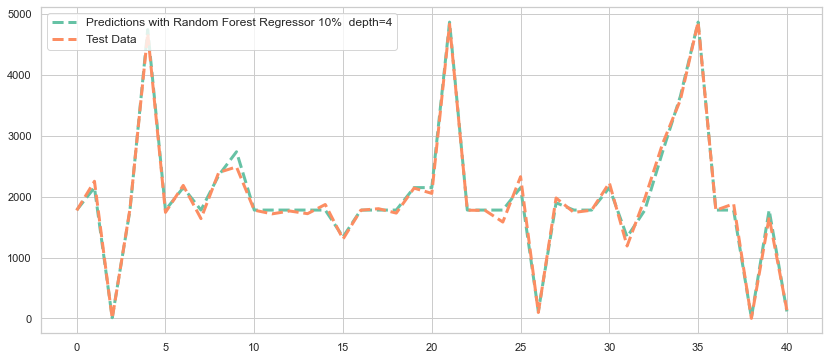

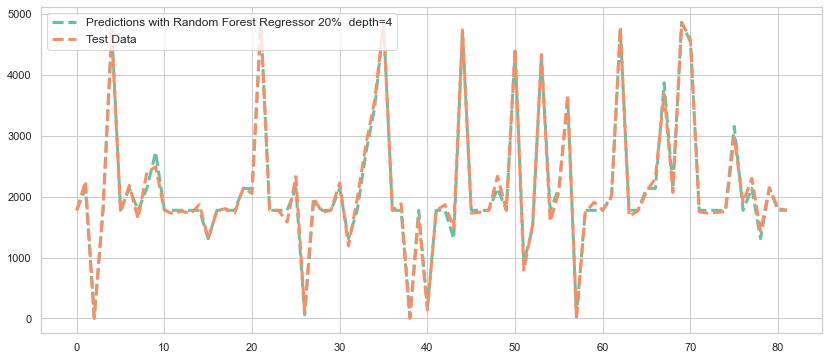

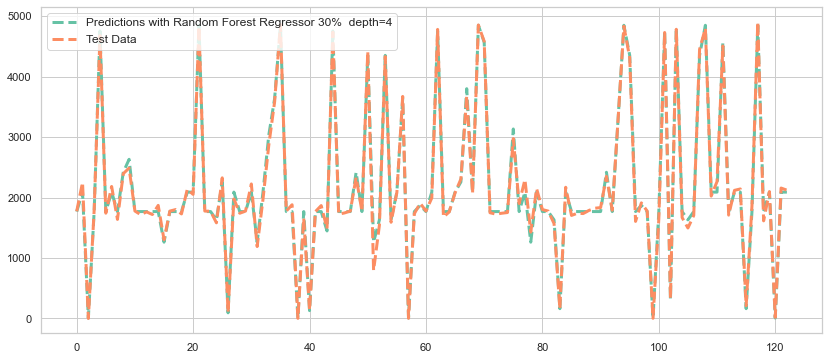

In [65]:
print('Random Forest Regressor')
random_forest_depth = 4
number_trees = 3

calculateRandomForest(10, 3, random_forest_depth, number_trees)
calculateRandomForest(20, 3, random_forest_depth, number_trees)
calculateRandomForest(30, 3, random_forest_depth, number_trees)

#### Conclusion

As we did for Decision Trees, we tested different depths for the forest and different number of trees. The best performance was the 30% test size. It is possible to conclude that this method shows better accuracy than Decision tree method. There is no over fitting or under fitting, because the test scores and training scores are quite similar and are really good.

### Models comparison

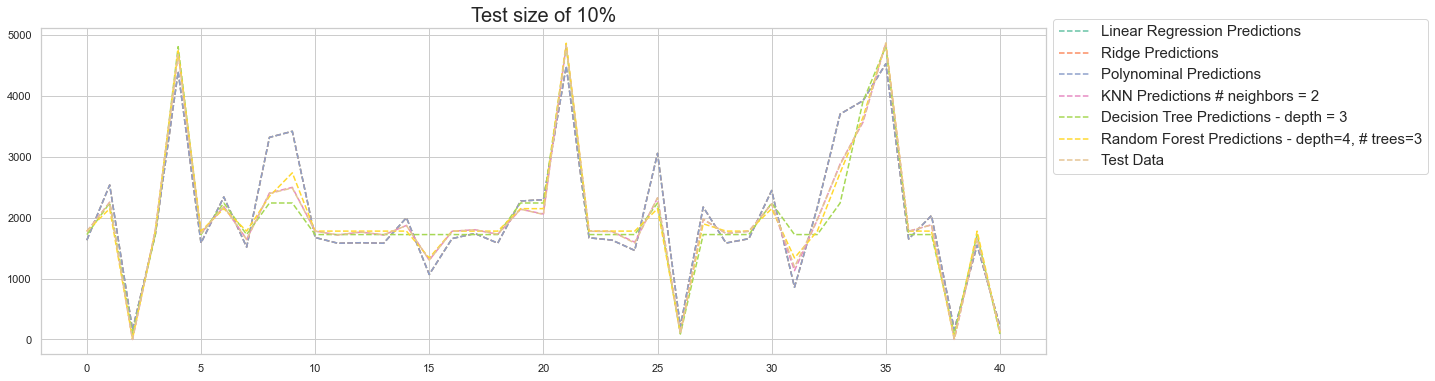

In [66]:
x_train10, x_test10, y_train10, y_test10 =  train_test_split(x, y, test_size = 0.10, random_state = 10)
plt.figure(figsize=(18, 6))
plt.plot(predictions_lin[0], linestyle = 'dashed', linewidth=1.5, label='Linear Regression Predictions')
plt.plot(predictions_ridge[0], linestyle = 'dashed', linewidth=1.5, label='Ridge Predictions')
plt.plot(polynominal_prediction[0], linestyle = 'dashed', linewidth=1.5, label='Polynominal Predictions')
plt.plot(predictions_knn[0], linestyle = 'dashed', linewidth=1.5, label='KNN Predictions # neighbors = {}'.format(num_neighbors))
plt.plot(decisiontree_prediction[0], linestyle = 'dashed', linewidth=1.5, label='Decision Tree Predictions - depth = {}'.format(decision_tree_depth))
plt.plot(predictions_randomforest[0], linestyle = 'dashed', linewidth=1.5, label='Random Forest Predictions - depth={}, # trees={}'.format(random_forest_depth, number_trees))
plt.plot(y_test10, linestyle = 'dashed', linewidth=1.5, label = 'Test Data')
plt.title("Test size of 10%", fontsize=20)
plt.legend(loc = 'best', fontsize=15, bbox_to_anchor=(1.0, 1.05));

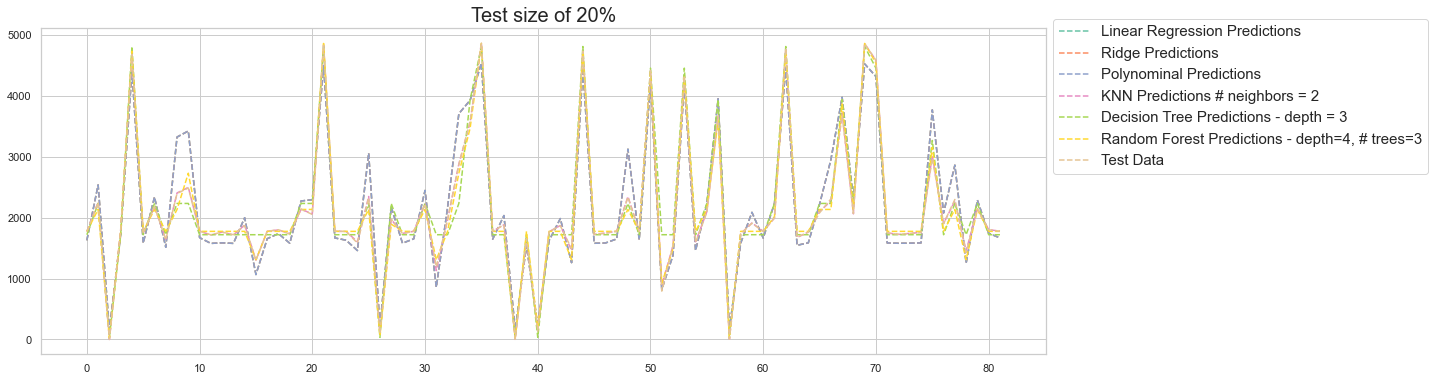

In [67]:
x_train20, x_test20, y_train20, y_test20 =  train_test_split(x, y, test_size = 0.20, random_state = 10)
plt.figure(figsize=(18, 6))
plt.plot(predictions_lin[1], linestyle = 'dashed', linewidth=1.5, label='Linear Regression Predictions')
plt.plot(predictions_ridge[1], linestyle = 'dashed', linewidth=1.5, label='Ridge Predictions')
plt.plot(polynominal_prediction[1], linestyle = 'dashed', linewidth=1.5, label='Polynominal Predictions')
plt.plot(predictions_knn[1], linestyle = 'dashed', linewidth=1.5, label='KNN Predictions # neighbors = {}'.format(num_neighbors))
plt.plot(decisiontree_prediction[1], linestyle = 'dashed', linewidth=1.5, label='Decision Tree Predictions - depth = {}'.format(decision_tree_depth))
plt.plot(predictions_randomforest[1], linestyle = 'dashed', linewidth=1.5, label='Random Forest Predictions - depth={}, # trees={}'.format(random_forest_depth, number_trees))
plt.plot(y_test20, linestyle = 'dashed', linewidth=1.5, label = 'Test Data')
plt.title("Test size of 20%", fontsize=20)
plt.legend(loc = 'best', fontsize=15, bbox_to_anchor=(1.0, 1.05));

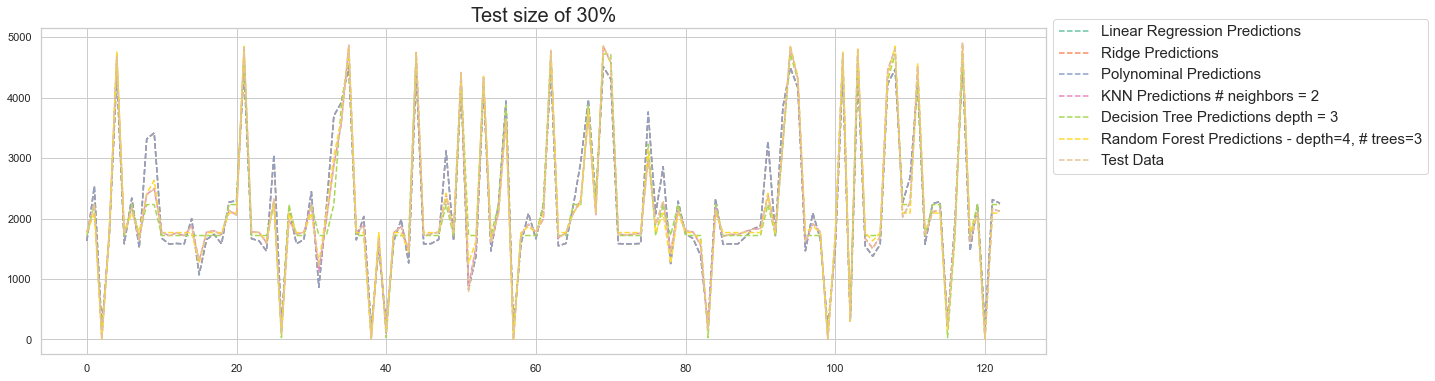

In [68]:
x_train30, x_test30, y_train30, y_test30 =  train_test_split(x, y, test_size = 0.30, random_state = 10)
plt.figure(figsize=(18, 6))
plt.plot(predictions_lin[2], linestyle = 'dashed', linewidth=1.5, label='Linear Regression Predictions')
plt.plot(predictions_ridge[2], linestyle = 'dashed', linewidth=1.5, label='Ridge Predictions')
plt.plot(polynominal_prediction[2], linestyle = 'dashed', linewidth=1.5, label='Polynominal Predictions')
plt.plot(predictions_knn[2], linestyle = 'dashed', linewidth=1.5, label='KNN Predictions # neighbors = {}'.format(num_neighbors))
plt.plot(decisiontree_prediction[2], linestyle = 'dashed', linewidth=1.5, label='Decision Tree Predictions depth = {}'.format(decision_tree_depth))
plt.plot(predictions_randomforest[2], linestyle = 'dashed', linewidth=1.5, label='Random Forest Predictions - depth={}, # trees={}'.format(random_forest_depth, number_trees))
plt.plot(y_test30, linestyle = 'dashed', linewidth=1.5, label = 'Test Data')
plt.title("Test size of 30%", fontsize=20)
plt.legend(loc = 'best', fontsize=15, bbox_to_anchor=(1.0, 1.05));

In [69]:
columns = ['Linear Regression', 'Ridge Regression', 'Polynominal Regression', 
           'KNN n={}'.format(num_neighbors), 'Decision Tree - depth={}'.format(decision_tree_depth),
            'Random Forest- depth={}, # trees={}'.format(random_forest_depth, number_trees)]

In [70]:
models10 = pd.DataFrame({
    'Model 10%': columns,
    'Test Score': [linear_test_accurancy[0], ridge_test_accurancy[0], polyregression_test_accurancy[0],
                        knn_test_accurancy[0], decisiontree_test_accurancy[0], randomforest_test_accurancy[0]],
    'Train Score': [linear_train_accuracy[0], ridge_train_accuracy[0], polyregression_train_accurancy[0],
                    knn_train_accuracy[0], decisiontree_train_accurancy[0], randomforest_train_accuracy[0]],
    'Cross Validation': [linear_cross_validation[0], ridge_cross_validation[0], polyregression_cross_validation[0],
                    knn_cross_validation[0], decisiontree_cross_validation[0], randomforest_cross_validation[0]]})

models20 = pd.DataFrame({
    'Model 20%': columns,
    'Test Score': [linear_test_accurancy[1], ridge_test_accurancy[1], polyregression_test_accurancy[1],
                        knn_test_accurancy[1], decisiontree_test_accurancy[1], randomforest_test_accurancy[1]],
    'Train Score': [linear_train_accuracy[1], ridge_train_accuracy[1], polyregression_train_accurancy[1],
                    knn_train_accuracy[1], decisiontree_train_accurancy[1], randomforest_train_accuracy[1]],
    'Cross Validation': [linear_cross_validation[1], ridge_cross_validation[1], polyregression_cross_validation[1],
                    knn_cross_validation[1], decisiontree_cross_validation[1], randomforest_cross_validation[1]]})


models30 = pd.DataFrame({
    'Model 30%': columns,
    'Test Score': [linear_test_accurancy[2], ridge_test_accurancy[2], polyregression_test_accurancy[2],
                        knn_test_accurancy[2], decisiontree_test_accurancy[2], randomforest_test_accurancy[2]],
    'Train Score': [linear_train_accuracy[2], ridge_train_accuracy[2], polyregression_train_accurancy[2],
                    knn_train_accuracy[2], decisiontree_train_accurancy[2], randomforest_train_accuracy[2]],
    'Cross Validation': [linear_cross_validation[2], ridge_cross_validation[2], polyregression_cross_validation[2],
                    knn_cross_validation[2], decisiontree_cross_validation[2], randomforest_cross_validation[2]]})


In [71]:
models10.sort_values(by='Test Score', ascending=False)

,Model 10%,Test Score,Train Score,Cross Validation
3,KNN n=2,99.987357,99.991068,99.179919
5,"Random Forest- depth=4, # trees=3",99.280679,99.589514,98.642437
4,Decision Tree - depth=3,96.924307,98.238145,95.174341
2,Polynominal Regression,95.531571,95.531571,90.721268
0,Linear Regression,90.531755,95.531571,90.721268
1,Ridge Regression,90.531755,95.531571,90.721268


In [72]:
models20.sort_values(by='Test Score', ascending=False)

,Model 20%,Test Score,Train Score,Cross Validation
3,KNN n=2,99.976444,99.990587,99.072336
5,"Random Forest- depth=4, # trees=3",99.248651,99.644147,99.011897
4,Decision Tree - depth=3,96.984544,98.309009,96.696130
2,Polynominal Regression,95.693597,95.693597,92.173109
0,Linear Regression,92.387023,95.693597,92.173109
1,Ridge Regression,92.387023,95.693597,92.173109


In [73]:
models30.sort_values(by='Test Score', ascending=False)

,Model 30%,Test Score,Train Score,Cross Validation
3,KNN n=2,99.981086,99.988797,99.609798
5,"Random Forest- depth=4, # trees=3",99.519383,99.716923,99.246850
4,Decision Tree - depth=3,98.055106,98.199417,97.536399
2,Polynominal Regression,95.546199,95.546199,93.422341
0,Linear Regression,94.268323,95.546199,93.422341
1,Ridge Regression,94.268323,95.546199,93.422341


Comparing all the models, we realized that using 30% test size the accuracy is better for all the models, according to Cross Validation method. We also can observe that there is no difference between Linear Regression and Ridge Regression, as expected, due to the fact that there is no over fitting in the model. For kNN, Decision Tree and Random Forest we got outstanding results with accuracy close to 100%.